In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchsummaryX import summary
import matplotlib.pyplot as plt
import time
import os

from UnarySim.sw.kernel.nn_utils import *
from UnarySim.sw.kernel.linear import UnaryLinear
from UnarySim.sw.kernel.relu import UnaryReLU
from UnarySim.sw.stream.gen import RNG, SourceGen, BSGen
from UnarySim.sw.metric.metric import ProgressiveError, NormStability
import time
import math
import numpy as np
import seaborn as sns
from tqdm import tqdm

In [3]:
cwd = os.getcwd()
print(cwd)

d:\project\Anaconda3\Lib\site-packages\UnarySim\sw\test\metric


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
print(device)

cpu


In [5]:
# MNIST data loader
transform=transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root=cwd+'/../data/mnist', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4)

testset = torchvision.datasets.MNIST(root=cwd+'/../data/mnist', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, num_workers=4)

# test binary model clamp

In [6]:
model_path = cwd+"\..\mlp\saved_model_state_dict"+"_8_clamp"
# model_path = cwd+"\..\mlp\saved_model_state_dict"+"_8_no_clamp_new"
# model_clamp = MLP3()
model_clamp = MLP3_clamp_eval()
model_clamp.to(device)
model_clamp.load_state_dict(torch.load(model_path))
model_clamp.eval()
model_clamp.to(device)
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model_clamp(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %f %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 97.100000 %


# test unary model nonscaled addition - clamp binary

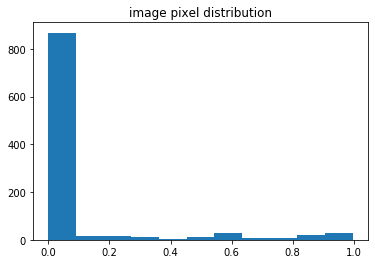

torch.Size([1, 1024])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 10])
torch.Size([1, 10])
ERR: min, max, mean
image:  -0.0038909316062927246 0.0038909311406314373 0.0010404111817479134
fc1:    -0.7890625 0.7734375 0.6465386748313904
relu1:  -0.7890625 0.0 0.5695587396621704
fc2:    -1.171875 1.171875 0.5785601139068604
relu2:  -0.8828125 0.4375 0.4017699658870697
fc3:    -1.3671875 0.2578125 0.5266401767730713
relu3:  -0.8828125 0.0078125 0.335082471370697

NS: min, max, mean
image:  0.8984375 1.0 0.934470534324646
fc1:    0.0 0.80078125 0.00836181640625
relu1:  0.0 0.92578125 0.22655487060546875
fc2:    0.0 0.0 0.0
relu1:  0.0 0.74609375 0.09844207763671875
fc3:    0.0 0.1411764770746231 0.014117647893726826
relu3:  0.0 0.9296875 0.5707031488418579

Accuracy of the network on 1 test images: 100.000000 %
Accuracy of the network on 1 test images: 100.000000 %


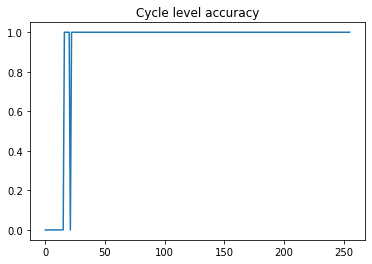

In [7]:
correct_binary = 0
correct_unary = 0

bitwidth = 8
total = 0

# binary MLP3_clamp weight init
rng = "Sobol"
encode = "RC"
rng_dim = 1
relu_buf_dep = 4
mode = "bipolar"
scaled = False
bias = True
sample_cnt = 1
threshold = 0.1

start_cnt = 0
current_index = 0

cycle_correct = torch.zeros(2**(bitwidth)).to(device)

start_time = time.time()

with torch.no_grad():
    for data in testloader:
        if current_index < start_cnt:
            current_index = current_index + 1
            continue
        current_index = current_index + 1

        total += labels.size(0)

        images, labels = data[0].to(device), data[1].to(device)
        
        # reference binary mlp
        outputs_binary = model_clamp(images)
        _, predicted_binary = torch.max(outputs_binary.data, 1)
        correct_binary += (predicted_binary == labels).sum().item()
        
#         print(model_clamp.fc1_out.min().item(), model_clamp.fc1_out.max().item())
#         print(model_clamp.fc2_out.min().item(), model_clamp.fc2_out.max().item())
#         print(model_clamp.fc3_out.min().item(), model_clamp.fc3_out.max().item())

        # unary part
        # input image check
        image = images.view(-1, 32*32)
        
        image_plot = image[0].cpu().numpy()
        fig = plt.hist(image_plot, bins='auto')  # arguments are passed to np.histogram
        plt.title("image pixel distribution")
        plt.show()
        
        image_SRC = SourceGen(image, bitwidth=bitwidth, mode=mode)().to(device)
        image_RNG = RNG(bitwidth, rng_dim, rng)().to(device)
        image_BSG = BSGen(image_SRC, image_RNG).to(device)
        image_ERR = ProgressiveError(image, mode=mode).to(device)
        image_NS = NormStability(image, mode=mode, threshold=threshold).to(device)
        
        # unary mlp is decomposed into separate layers
        fc1_unary = UnaryLinear(32*32, 512, model_clamp.fc1.weight.data, model_clamp.fc1.bias.data, 
                                bitwidth=bitwidth, mode=mode, scaled=scaled, bias=bias).to(device)
        fc1_ERR = ProgressiveError(model_clamp.fc1_out.clamp(-1, 1), mode=mode).to(device)
        fc1_NS = NormStability(model_clamp.fc1_out.clamp(-1, 1), mode=mode, threshold=threshold).to(device)

        fc2_unary = UnaryLinear(512, 512, model_clamp.fc2.weight.data, model_clamp.fc2.bias.data, 
                                bitwidth=bitwidth, mode=mode, scaled=scaled, bias=bias).to(device)
        fc2_ERR = ProgressiveError(model_clamp.fc2_out.clamp(-1, 1), mode=mode).to(device)
        fc2_NS = NormStability(model_clamp.fc2_out.clamp(-1, 1), mode=mode, threshold=threshold).to(device)

        fc3_unary = UnaryLinear(512, 10, model_clamp.fc3.weight.data, model_clamp.fc3.bias.data, 
                                bitwidth=bitwidth, mode=mode, scaled=scaled, bias=bias).to(device)
        fc3_ERR = ProgressiveError(model_clamp.fc3_out.clamp(-1, 1), mode=mode).to(device)
        fc3_NS = NormStability(model_clamp.fc3_out.clamp(-1, 1), mode=mode, threshold=threshold).to(device)

        relu1_unary = UnaryReLU(depth=relu_buf_dep, bitwidth=bitwidth, encode=encode).to(device)
        relu1_ERR = ProgressiveError(model_clamp.relu1_out.clamp(-1, 1), mode=mode).to(device)
        relu1_NS = NormStability(model_clamp.relu1_out.clamp(-1, 1), mode=mode, threshold=threshold).to(device)

        relu2_unary = UnaryReLU(depth=relu_buf_dep, bitwidth=bitwidth, encode=encode).to(device)
        relu2_ERR = ProgressiveError(model_clamp.relu2_out.clamp(-1, 1), mode=mode).to(device)
        relu2_NS = NormStability(model_clamp.relu2_out.clamp(-1, 1), mode=mode, threshold=threshold).to(device)
        
#         relu3_unary = UnaryReLU(depth=relu_buf_dep, bitwidth=bitwidth, encode=encode).to(device)
#         relu3_ERR = ProgressiveError(model_clamp.relu3_out.clamp(-1, 1), mode=mode).to(device)
#         relu3_NS = NormStability(model_clamp.relu3_out.clamp(-1, 1), mode=mode, threshold=threshold).to(device)
        
        if total%100 == 0:
            print("--- %s seconds ---" % (time.time() - start_time))
            print(total, "images are done!!!")

#         print(current_index, "-th image with label", labels.item(), ", total image count", total)
        for i in range(2**(bitwidth)):
            idx = torch.zeros(image_SRC.size()).type(torch.long).to(device)
            image_bs = image_BSG(idx + i)
            image_ERR.Monitor(image_bs)
            image_NS.Monitor(image_bs)

            # fc1
            fc1_unary_out   = fc1_unary(image_bs)
            fc1_ERR.Monitor(fc1_unary_out)
            fc1_NS.Monitor(fc1_unary_out)

            # relu1
            relu1_unary_out = relu1_unary(fc1_unary_out)
            relu1_ERR.Monitor(relu1_unary_out)
            relu1_NS.Monitor(relu1_unary_out)
            
            # fc2
            fc2_unary_out   = fc2_unary(relu1_unary_out)
            fc2_ERR.Monitor(fc2_unary_out)
            fc2_NS.Monitor(fc2_unary_out)
            
            # relu2
            relu2_unary_out = relu2_unary(fc2_unary_out)
            relu2_ERR.Monitor(relu2_unary_out)
            relu2_NS.Monitor(relu2_unary_out)
            
            # fc3
            fc3_unary_out   = fc3_unary(relu2_unary_out)
            fc3_ERR.Monitor(fc3_unary_out)
            fc3_NS.Monitor(fc3_unary_out)
            
            # relu3
#             relu3_unary_out = relu3_unary(fc3_unary_out)
#             relu3_ERR.Monitor(relu3_unary_out)
#             relu3_NS.Monitor(relu3_unary_out)
            
            _, predicted_unary = torch.max(fc3_ERR()[0], 1)
            if predicted_unary == labels:
#                 print(current_index, "-th image succeeds.")
#                 print(current_index, "-th image with label", labels.item(), ", total image count", total)
#                 print("before", predicted_unary.item(), cycle_correct[predicted_unary.item()].item())
                cycle_correct[i].add_(1)
#                 print("after", predicted_unary.item(), cycle_correct[predicted_unary.item()].item())
        
        print(image_bs.shape)
        print(fc1_unary_out.shape)
        print(relu1_unary_out.shape)
        print(fc2_unary_out.shape)
        print(relu2_unary_out.shape)
        print(fc3_unary_out.shape)
        print(relu3_unary_out.shape)
        
#         fc1_out_plot_b = model_clamp.fc1_out[0].cpu().numpy()
# #         fig = plt.hist(fc1_out_plot_b, bins='auto')  # arguments are passed to np.histogram
#         fig = plt.plot(fc1_out_plot_b)  # arguments are passed to np.histogram
#         plt.title("fc1_out_plot_b distribution")
#         plt.show()
        
#         fc1_out_plot_u = fc1_ERR()[1][0].cpu().numpy()
# #         fig = plt.hist(fc1_out_plot_u, bins='auto')  # arguments are passed to np.histogram
#         fig = plt.plot(fc1_out_plot_u)  # arguments are passed to np.histogram
#         plt.title("fc1_out_plot_u distribution")
#         plt.show()
        
        to_print = 1
        print("ERR: min, max, mean")
        print("image: ", 
              image_ERR()[to_print].min().item(), 
              image_ERR()[to_print].max().item(),
              image_ERR()[to_print].mul(image_ERR()[to_print]).mean().sqrt().item())
        print("fc1:   ", 
              fc1_ERR()[to_print].min().item(), 
              fc1_ERR()[to_print].max().item(), 
              fc1_ERR()[to_print].mul(fc1_ERR()[to_print]).mean().sqrt().item())
        print("relu1: ", 
              relu1_ERR()[to_print].min().item(), 
              relu1_ERR()[to_print].max().item(), 
              relu1_ERR()[to_print].mul(relu1_ERR()[to_print]).mean().sqrt().item())
        print("fc2:   ", 
              fc2_ERR()[to_print].min().item(), 
              fc2_ERR()[to_print].max().item(), 
              fc2_ERR()[to_print].mul(fc2_ERR()[to_print]).mean().sqrt().item())
        print("relu2: ", 
              relu2_ERR()[to_print].min().item(), 
              relu2_ERR()[to_print].max().item(), 
              relu2_ERR()[to_print].mul(relu2_ERR()[to_print]).mean().sqrt().item())
        print("fc3:   ", 
              fc3_ERR()[to_print].min().item(), 
              fc3_ERR()[to_print].max().item(), 
              fc3_ERR()[to_print].mul(fc3_ERR()[to_print]).mean().sqrt().item())
        print("relu3: ", 
              relu3_ERR()[to_print].min().item(), 
              relu3_ERR()[to_print].max().item(), 
              relu3_ERR()[to_print].mul(relu3_ERR()[to_print]).mean().sqrt().item())
        print()
        
        to_print = 1
        print("NS: min, max, mean")
        print("image: ", 
              image_NS().min().item(), 
              image_NS().max().item(),
              image_NS().mean().item())
        print("fc1:   ", 
              fc1_NS().min().item(), 
              fc1_NS().max().item(), 
              fc1_NS().mean().item())
        print("relu1: ", 
              relu1_NS().min().item(), 
              relu1_NS().max().item(), 
              relu1_NS().mean().item())
        print("fc2:   ", 
              fc2_NS().min().item(), 
              fc2_NS().max().item(), 
              fc2_NS().mean().item())
        print("relu1: ", 
              relu2_NS().min().item(), 
              relu2_NS().max().item(), 
              relu2_NS().mean().item())
        print("fc3:   ", 
              fc3_NS().min().item(), 
              fc3_NS().max().item(), 
              fc3_NS().mean().item())
        print("relu3: ", 
              relu3_NS().min().item(), 
              relu3_NS().max().item(), 
              relu3_NS().mean().item())
        print()
        _, predicted_unary = torch.max(relu3_ERR()[0], 1)
        correct_unary += (predicted_unary == labels).sum().item()
        if total == sample_cnt:
            break

print('Accuracy of the network on %d test images: %f %%' % (total,
    100 * correct_binary / total))
print('Accuracy of the network on %d test images: %f %%' % (total,
    100 * correct_unary / total))

result = cycle_correct.cpu().numpy()/total
fig = plt.plot([i for i in range(2**bitwidth)], result)  # arguments are passed to np.histogram
plt.title("Cycle level accuracy")
plt.show()



In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [9]:
# model_path = cwd+"\..\mlp\saved_model_state_dict"+"_8_clamp"
model_path = cwd+"\..\mlp\saved_model_state_dict"+"_8_no_clamp_new"
model_clamp = MLP3()
# model_clamp = MLP3_clamp_eval()
model_clamp.to(device)
model_clamp.load_state_dict(torch.load(model_path))
model_clamp.eval()
model_clamp.to(device)
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model_clamp(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %f %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 97.100000 %


--- 138.1310007572174 seconds ---
100 images are done!!!
Accuracy of the network on 100 test images: 98.000000 %
--- 280.5559997558594 seconds ---
200 images are done!!!
Accuracy of the network on 200 test images: 98.500000 %
--- 420.93299984931946 seconds ---
300 images are done!!!
Accuracy of the network on 300 test images: 97.666667 %
--- 561.0060012340546 seconds ---
400 images are done!!!
Accuracy of the network on 400 test images: 97.500000 %
--- 704.9860014915466 seconds ---
500 images are done!!!
Accuracy of the network on 500 test images: 97.400000 %
--- 844.1140003204346 seconds ---
600 images are done!!!
Accuracy of the network on 600 test images: 97.333333 %
--- 985.694000005722 seconds ---
700 images are done!!!
Accuracy of the network on 700 test images: 97.142857 %
--- 1128.1059999465942 seconds ---
800 images are done!!!
Accuracy of the network on 800 test images: 96.875000 %
--- 1268.065000295639 seconds ---
900 images are done!!!
Accuracy of the network on 900 test im

7200 images are done!!!
Accuracy of the network on 7200 test images: 96.750000 %
--- 10286.62800002098 seconds ---
7300 images are done!!!
Accuracy of the network on 7300 test images: 96.780822 %
--- 10428.035999536514 seconds ---
7400 images are done!!!
Accuracy of the network on 7400 test images: 96.824324 %
--- 10568.253999948502 seconds ---
7500 images are done!!!
Accuracy of the network on 7500 test images: 96.813333 %
--- 10710.16100025177 seconds ---
7600 images are done!!!
Accuracy of the network on 7600 test images: 96.855263 %
--- 10852.133999824524 seconds ---
7700 images are done!!!
Accuracy of the network on 7700 test images: 96.896104 %
--- 10992.888000488281 seconds ---
7800 images are done!!!
Accuracy of the network on 7800 test images: 96.935897 %
--- 11134.673000574112 seconds ---
7900 images are done!!!
Accuracy of the network on 7900 test images: 96.924051 %
--- 11274.849000692368 seconds ---
8000 images are done!!!
Accuracy of the network on 8000 test images: 96.93

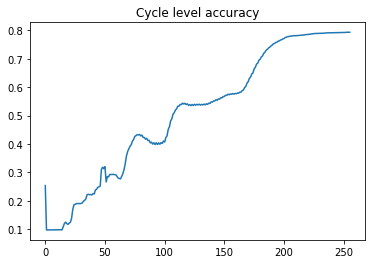

In [10]:
correct_binary = 0
correct_unary = 0

bitwidth = 8
total = 0

# binary MLP3_clamp weight init
rng = "Sobol"
encode = "RC"
rng_dim = 1
relu_buf_dep = 4
mode = "bipolar"
scaled = False
bias = True
sample_cnt = 50000
threshold = 0.1

start_cnt = 0
current_index = 0

cycle_correct = torch.zeros(2**(bitwidth)).to(device)

start_time = time.time()

with torch.no_grad():
    for data in testloader:
        if current_index < start_cnt:
            current_index = current_index + 1
            continue
        current_index = current_index + 1

        total += labels.size(0)

        images, labels = data[0].to(device), data[1].to(device)
        
        # reference binary mlp
        outputs_binary = model_clamp(images)
        _, predicted_binary = torch.max(outputs_binary.data, 1)
        correct_binary += (predicted_binary == labels).sum().item()
        
#         print(model_clamp.fc1_out.min().item(), model_clamp.fc1_out.max().item())
#         print(model_clamp.fc2_out.min().item(), model_clamp.fc2_out.max().item())
#         print(model_clamp.fc3_out.min().item(), model_clamp.fc3_out.max().item())

        # unary part
        # input image check
        image = images.view(-1, 32*32)
        
#         image_plot = image[0].cpu().numpy()
#         fig = plt.hist(image_plot, bins='auto')  # arguments are passed to np.histogram
#         plt.title("image pixel distribution")
#         plt.show()
        
        image_SRC = SourceGen(image, bitwidth=bitwidth, mode=mode)().to(device)
        image_RNG = RNG(bitwidth, rng_dim, rng)().to(device)
        image_BSG = BSGen(image_SRC, image_RNG).to(device)
#         image_ERR = ProgressiveError(image, mode=mode).to(device)
#         image_NS = NormStability(image, mode=mode, threshold=threshold).to(device)
        
        # unary mlp is decomposed into separate layers
        fc1_unary = UnaryLinear(32*32, 512, model_clamp.fc1.weight.data, model_clamp.fc1.bias.data, 
                                bitwidth=bitwidth, mode=mode, scaled=scaled, bias=bias).to(device)
#         fc1_ERR = ProgressiveError(model_clamp.fc1_out.clamp(-1, 1), mode=mode).to(device)
#         fc1_NS = NormStability(model_clamp.fc1_out.clamp(-1, 1), mode=mode, threshold=threshold).to(device)

        fc2_unary = UnaryLinear(512, 512, model_clamp.fc2.weight.data, model_clamp.fc2.bias.data, 
                                bitwidth=bitwidth, mode=mode, scaled=scaled, bias=bias).to(device)
#         fc2_ERR = ProgressiveError(model_clamp.fc2_out.clamp(-1, 1), mode=mode).to(device)
#         fc2_NS = NormStability(model_clamp.fc2_out.clamp(-1, 1), mode=mode, threshold=threshold).to(device)

        fc3_unary = UnaryLinear(512, 10, model_clamp.fc3.weight.data, model_clamp.fc3.bias.data, 
                                bitwidth=bitwidth, mode=mode, scaled=scaled, bias=bias).to(device)
#         fc3_ERR = ProgressiveError(model_clamp.fc3_out.clamp(-1, 1), mode=mode).to(device)
#         fc3_NS = NormStability(model_clamp.fc3_out.clamp(-1, 1), mode=mode, threshold=threshold).to(device)

        relu1_unary = UnaryReLU(depth=relu_buf_dep, bitwidth=bitwidth, encode=encode).to(device)
#         relu1_ERR = ProgressiveError(model_clamp.relu1_out.clamp(-1, 1), mode=mode).to(device)
#         relu1_NS = NormStability(model_clamp.relu1_out.clamp(-1, 1), mode=mode, threshold=threshold).to(device)

        relu2_unary = UnaryReLU(depth=relu_buf_dep, bitwidth=bitwidth, encode=encode).to(device)
#         relu2_ERR = ProgressiveError(model_clamp.relu2_out.clamp(-1, 1), mode=mode).to(device)
#         relu2_NS = NormStability(model_clamp.relu2_out.clamp(-1, 1), mode=mode, threshold=threshold).to(device)
        
        relu3_unary = UnaryReLU(depth=relu_buf_dep, bitwidth=bitwidth, encode=encode).to(device)
        relu3_ERR = ProgressiveError(model_clamp.relu3_out.clamp(-1, 1), mode=mode).to(device)
#         relu3_NS = NormStability(model_clamp.relu3_out.clamp(-1, 1), mode=mode, threshold=threshold).to(device)
        
        if total%100 == 0:
            print("--- %s seconds ---" % (time.time() - start_time))
            print(total, "images are done!!!")
            print('Accuracy of the network on %d test images: %f %%' % (total,
    100 * correct_unary / total))

#         print(current_index, "-th image with label", labels.item(), ", total image count", total)
        for i in range(2**(bitwidth)):
            idx = torch.zeros(image_SRC.size()).type(torch.long).to(device)
            image_bs = image_BSG(idx + i)
#             image_ERR.Monitor(image_bs)
#             image_NS.Monitor(image_bs)

            # fc1
            fc1_unary_out   = fc1_unary(image_bs)
#             fc1_ERR.Monitor(fc1_unary_out)
#             fc1_NS.Monitor(fc1_unary_out)

            # relu1
            relu1_unary_out = relu1_unary(fc1_unary_out)
#             relu1_ERR.Monitor(relu1_unary_out)
#             relu1_NS.Monitor(relu1_unary_out)
            
            # fc2
            fc2_unary_out   = fc2_unary(relu1_unary_out)
#             fc2_ERR.Monitor(fc2_unary_out)
#             fc2_NS.Monitor(fc2_unary_out)
            
            # relu2
            relu2_unary_out = relu2_unary(fc2_unary_out)
#             relu2_ERR.Monitor(relu2_unary_out)
#             relu2_NS.Monitor(relu2_unary_out)
            
            # fc3
            fc3_unary_out   = fc3_unary(relu2_unary_out)
#             fc3_ERR.Monitor(fc3_unary_out)
#             fc3_NS.Monitor(fc3_unary_out)
            
            # relu3
            relu3_unary_out = relu3_unary(fc3_unary_out)
            relu3_ERR.Monitor(relu3_unary_out)
#             relu3_NS.Monitor(relu3_unary_out)
            
            _, predicted_unary = torch.max(relu3_ERR()[0], 1)
            if predicted_unary == labels:
#                 print(current_index, "-th image succeeds.")
#                 print(current_index, "-th image with label", labels.item(), ", total image count", total)
#                 print("before", predicted_unary.item(), cycle_correct[predicted_unary.item()].item())
                cycle_correct[i].add_(1)
#                 print("after", predicted_unary.item(), cycle_correct[predicted_unary.item()].item())
        
#         print(image_bs.shape)
#         print(fc1_unary_out.shape)
#         print(relu1_unary_out.shape)
#         print(fc2_unary_out.shape)
#         print(relu2_unary_out.shape)
#         print(fc3_unary_out.shape)
#         print(relu3_unary_out.shape)
        
#         fc1_out_plot_b = model_clamp.fc1_out[0].cpu().numpy()
# #         fig = plt.hist(fc1_out_plot_b, bins='auto')  # arguments are passed to np.histogram
#         fig = plt.plot(fc1_out_plot_b)  # arguments are passed to np.histogram
#         plt.title("fc1_out_plot_b distribution")
#         plt.show()
        
#         fc1_out_plot_u = fc1_ERR()[1][0].cpu().numpy()
# #         fig = plt.hist(fc1_out_plot_u, bins='auto')  # arguments are passed to np.histogram
#         fig = plt.plot(fc1_out_plot_u)  # arguments are passed to np.histogram
#         plt.title("fc1_out_plot_u distribution")
#         plt.show()
        
#         to_print = 1
#         print("ERR: min, max, mean")
#         print("image: ", 
#               image_ERR()[to_print].min().item(), 
#               image_ERR()[to_print].max().item(),
#               image_ERR()[to_print].mul(image_ERR()[to_print]).mean().sqrt().item())
#         print("fc1:   ", 
#               fc1_ERR()[to_print].min().item(), 
#               fc1_ERR()[to_print].max().item(), 
#               fc1_ERR()[to_print].mul(fc1_ERR()[to_print]).mean().sqrt().item())
#         print("relu1: ", 
#               relu1_ERR()[to_print].min().item(), 
#               relu1_ERR()[to_print].max().item(), 
#               relu1_ERR()[to_print].mul(relu1_ERR()[to_print]).mean().sqrt().item())
#         print("fc2:   ", 
#               fc2_ERR()[to_print].min().item(), 
#               fc2_ERR()[to_print].max().item(), 
#               fc2_ERR()[to_print].mul(fc2_ERR()[to_print]).mean().sqrt().item())
#         print("relu2: ", 
#               relu2_ERR()[to_print].min().item(), 
#               relu2_ERR()[to_print].max().item(), 
#               relu2_ERR()[to_print].mul(relu2_ERR()[to_print]).mean().sqrt().item())
#         print("fc3:   ", 
#               fc3_ERR()[to_print].min().item(), 
#               fc3_ERR()[to_print].max().item(), 
#               fc3_ERR()[to_print].mul(fc3_ERR()[to_print]).mean().sqrt().item())
#         print("relu3: ", 
#               relu3_ERR()[to_print].min().item(), 
#               relu3_ERR()[to_print].max().item(), 
#               relu3_ERR()[to_print].mul(relu3_ERR()[to_print]).mean().sqrt().item())
#         print()
        
#         to_print = 1
#         print("NS: min, max, mean")
#         print("image: ", 
#               image_NS().min().item(), 
#               image_NS().max().item(),
#               image_NS().mean().item())
#         print("fc1:   ", 
#               fc1_NS().min().item(), 
#               fc1_NS().max().item(), 
#               fc1_NS().mean().item())
#         print("relu1: ", 
#               relu1_NS().min().item(), 
#               relu1_NS().max().item(), 
#               relu1_NS().mean().item())
#         print("fc2:   ", 
#               fc2_NS().min().item(), 
#               fc2_NS().max().item(), 
#               fc2_NS().mean().item())
#         print("relu1: ", 
#               relu2_NS().min().item(), 
#               relu2_NS().max().item(), 
#               relu2_NS().mean().item())
#         print("fc3:   ", 
#               fc3_NS().min().item(), 
#               fc3_NS().max().item(), 
#               fc3_NS().mean().item())
#         print("relu3: ", 
#               relu3_NS().min().item(), 
#               relu3_NS().max().item(), 
#               relu3_NS().mean().item())
#         print()
        _, predicted_unary = torch.max(relu3_ERR()[0], 1)
        correct_unary += (predicted_unary == labels).sum().item()
        if total == sample_cnt:
            break

print('Accuracy of the network on %d test images: %f %%' % (total,
    100 * correct_binary / total))
print('Accuracy of the network on %d test images: %f %%' % (total,
    100 * correct_unary / total))

result = cycle_correct.cpu().numpy()/total
fig = plt.plot([i for i in range(2**bitwidth)], result)  # arguments are passed to np.histogram
plt.title("Cycle level accuracy")
plt.show()

with open("cycle_accuracy_mlp_nonscaled_no_clamp_new.csv", "w+") as f:
    for i in result:
        f.write(str(i)+", \n")